In [1]:
%pip install -q -r ../../requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os
print(load_dotenv('../../.env'))
print(os.environ['LANGSMITH_PROJECT'])

True
agentic-ops


In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

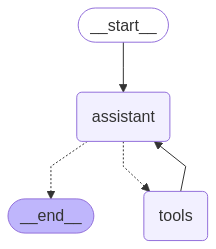

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZOF6pIQwzGUdaMeOchCJxmMF)
 Call ID: call_ZOF6pIQwzGUdaMeOchCJxmMF
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='4c100e33-703e-43ff-8003-74800d281cfb')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f031cb9-585c-690e-8000-0a84854f031b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-15T20:31:30.518034+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f031cb9-585a-6654-bfff-07ae6e10e6ed'}}, tasks=(PregelTask(id='5a126606-2eef-d631-1ce4-25c9ce7243bb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

## Look at all the history

In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='2ba987ff-052f-42e7-83b9-cf0ec27b1fc1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZOF6pIQwzGUdaMeOchCJxmMF', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BXZfEjUHBFwQKSNKTTvgVl67lJKz4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2204b4c6-599b-4e26-aa72-1121e90070f9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ZOF6pIQ

In [11]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)

5

In [13]:
to_replay = all_states[-2]
to_replay.values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='2ba987ff-052f-42e7-83b9-cf0ec27b1fc1')]

In [14]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f031ccc-ed6c-6cf2-8000-a33ca0cca168'}}

## Just pass the checkpoint_id

In [15]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_UO51wF4bBsa0oSKGqVKWfJCZ)
 Call ID: call_UO51wF4bBsa0oSKGqVKWfJCZ
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


# Forking

In [16]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='2ba987ff-052f-42e7-83b9-cf0ec27b1fc1')]

In [17]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f031ccc-ed6c-6cf2-8000-a33ca0cca168'}}

In [18]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [19]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f031cdd-f15b-64ce-8001-cfae6ce98561'}}

In [21]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"] # 0 is the latest

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='2ba987ff-052f-42e7-83b9-cf0ec27b1fc1')]

In [27]:
for snap in all_states:
    print(snap.values) 
# our latest messages doesn't have all the other previous stages in state updates. This shows its never run before
# the id of latest message will override the previous one

{'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='2ba987ff-052f-42e7-83b9-cf0ec27b1fc1')]}
{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='2ba987ff-052f-42e7-83b9-cf0ec27b1fc1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UO51wF4bBsa0oSKGqVKWfJCZ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BXZj0UaIVZKOwxT8k7tIDTFT3ejCE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='r

## with forking Graph re-runs when state updated

In [25]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jLV6x5G1OKiZmvYoJuS48kqP)
 Call ID: call_jLV6x5G1OKiZmvYoJuS48kqP
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.
